This project will focus on Asian call option pricing using Monte Carlo simulations. We want to show the effect of control variate on the variance of the simulations.

# Pricing with classic Monte Carlo simulations 


The payoff of an Asian option with stike $K$ is: $$ \bigg(\sum_{t=1}^T \frac{S(t)}{T} - K \bigg)^+$$ where $T$ is the maturity date and $S(t)$ the price of the underlying stock at time $t \in [0,T]$.

In order to simulate the price of the option, we use Black-Scholes SDE: $$ dS(t) = rS(t)dt+\sigma S(t)dW(t) $$ where $r$ is the risk free rate and $\sigma$ the stock volatility. We simulate paths for stock prices using this formula and compute the payoff. The price of the call at time $t=0$ is given using the martingale property : $$C_0(S,K,r,T) = e^{-rT}E_0\bigg[\bigg(\sum_{t=1}^T \frac{S(t)}{T} - K \bigg)^+\bigg]$$

In [114]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

def AsianMC(T,S,K,sigma,r,NPaths,NSteps):
    if NPaths <= 1:
        print("2 sample paths are required at minimum")
        return
    dt = T/NSteps
    sqrtdt = np.sqrt(dt)
    S_vec = S*np.ones([NSteps+1,NPaths])
    for t in range(NSteps):
        dW = np.random.normal(0,sqrtdt,NPaths)
        S_vec[t+1,:] = S_vec[t,:] + r*S_vec[t,:]*dt  +  sigma * S_vec[t,:] * dW
    S_mean = np.mean(S_vec[1:,:],axis=0) #Don't keep S0, only 1 to NSteps
    payoff = np.maximum(S_mean - K ,0)
    
    pv_vec =  np.exp(-r*T) * payoff
    pv = np.mean(pv_vec)
    varpv = np.var(pv_vec,ddof=1)
    i1 = pv - 1.96*np.sqrt(varpv)/np.sqrt(NPaths)
    i2 = pv + 1.96*np.sqrt(varpv)/np.sqrt(NPaths)
    return i1,i2,pv,pv_vec


# Pricing with Monte Carlo with control variate 

We choose the geometric average Asian option as control variate with payoff :
\begin{align*}
\bigg[\bigg(\prod_{i=1}^{N}S(t_n) \bigg)^{1/N} - K \bigg]^+
\end{align*}
where $t_N = T$ and $t_0 = 0$, $N$ is the number of steps in which we split the time to maturity. It has an analytical solution:
\begin{align*}
P_{GA} &= e^{-rT}\big[e^{a+\frac{1}{2}b}N(x) - KN(x-\sqrt{b})\big]\\
a &= log(S_0) + \nu dt + \frac{1}{2}\nu(T-dt) \\
b &= \sigma^2 dt + \frac{\sigma^2 (T-dt)}{6N}(2N-1) \\
\nu &= r - \frac{1}{2}\sigma^2 \\
x &= \frac{a-log(K)+b}{\sqrt{b}}
\end{align*}

In [115]:
def AnalyticalGeom(T,S,K,sigma,r,NSteps):
    dt = T/NSteps
    
    v = r - 0.5*sigma**2 
    a = np.log(S) + v*dt + 0.5*v*(T-dt)
    b = sigma**2 * dt + (sigma**2 * (T-dt) )/(6*NSteps) * (2*NSteps -1)
    x = (a - np.log(K) + b) / np.sqrt(b)
    
    price = np.exp(-r*T) * (np.exp(a + 0.5*b) * norm.cdf(x) - K * norm.cdf(x-np.sqrt(b)))
    return price

In the MC with CV method, the price of the Asian call option is given by:
\begin{align*}
C_0(S,K,r,T) = E[X + c^* (Y - u)]
\end{align*}
where $X$ is the arithmetic price, $Y$ is the geometric price and $u$ is the analytical value of the geometric price. $c^* = -\frac{Cov(X,Y)}{Var(Y)}$

First we need to estimate $c^*$ with a pilot Monte Carlo:

In [116]:
def MCPilot(T,S,K,sigma,r,NPaths,NSteps): 
    if NPaths <= 1:
        print("2 sample paths are required at minimum")
        return
    dt = T/NSteps
    sqrtdt = np.sqrt(dt)
    S_vec = S*np.ones([NSteps+1,NPaths])
    for t in range(NSteps):
        dW = np.random.normal(0,sqrtdt,NPaths)
        S_vec[t+1,:] = S_vec[t,:] + r*S_vec[t,:]*dt  +  sigma * S_vec[t,:] * dW
    ari_price = np.exp(-r*T)*np.maximum(np.mean(S_vec[1:,:],axis=0)-K,0)
    geom_price = np.exp(-r*T)*np.maximum(np.exp(np.mean(np.log(S_vec[1:,:]),axis=0))-K , 0)
    varcovar = np.cov(ari_price,geom_price)
    return(-varcovar[0,1]/np.var(geom_price,ddof=1))

Then we implement the Monte Carlo simulations: 

In [117]:
def AsianMCCV(T,S,K,sigma,r,NPaths,NSteps):
    if NPaths <= 1:
        print("2 sample paths are required at minimum")
        return
    c_star = MCPilot(T,S,K,sigma,r,NPaths,NSteps)
    geom_anal = AnalyticalGeom(T,S,K,sigma,r,NSteps)
    
    dt = T/NSteps
    sqrtdt = np.sqrt(dt)
    S_vec = S*np.ones([NSteps+1,NPaths])
    for t in range(NSteps):
        dW = np.random.normal(0,sqrtdt,NPaths)
        S_vec[t+1,:] = S_vec[t,:] + r*S_vec[t,:]*dt  +  sigma * S_vec[t,:] * dW
    ari_price = np.exp(-r*T)*np.maximum(np.mean(S_vec[1:,:],axis=0)-K,0)
    geom_price = np.exp(-r*T)*np.maximum(np.exp(np.mean(np.log(S_vec[1:,:]),axis=0))-K , 0)
    
    pv_vec = ari_price + c_star * (geom_price - geom_anal)
    varprice = np.var(pv_vec,ddof=1)
    sigsqrtn = varprice/np.sqrt(NPaths)    
    pv = np.mean(pv_vec)
    i1 = pv - 1.96*sigsqrtn
    i2=  pv + 1.96*sigsqrtn
    return i1,i2,pv,pv_vec,c_star

#  Price and variance comparison
## Example 1

For the first example we set:
\begin{align*}
T &= 2 \\
S &= 20 \\
K &= 15 \\
\sigma &= 0.3 \\
r &= 0.05 \\
NPaths &= 10000 \\ 
NSteps &= 200T
\end{align*}

In [118]:
T = 2
S = 20
K = 15
sigma = 0.3
r = 0.05 
NPaths = 10000
NSteps = 200 * T

Then we print the prices along with the 95% confidence intervals for both methods:

In [119]:
MC = AsianMC(T,S,K,sigma,r,NPaths,NSteps)
MC_CV = AsianMCCV(T,S,K,sigma,r,NPaths,NSteps)
print('#### Price w/o CV ####')
print ("lower boundary: ",MC[0])
print ("Higher boundary: ",MC[1])
print("Price:",MC[2])


print('\n #### Price w/ CV ####')
print ("lower boundary: ",MC_CV[0])
print ("Higher boundary: ",MC_CV[1])
print("Price:",MC_CV[2])
print("c*: ",MC_CV[4])

#### Price w/o CV ####
lower boundary:  5.476398913231674
Higher boundary:  5.659126243941018
Price: 5.567762578586346

 #### Price w/ CV ####
lower boundary:  5.599019004403903
Higher boundary:  5.601612146733837
Price: 5.60031557556887
c*:  -1.0470041522047413


It is obvious that the confidence interval for MC with CV is smaller than the one without. We can explicit it by showing a graph of the distributions of the prices given by the 2 simulations. 

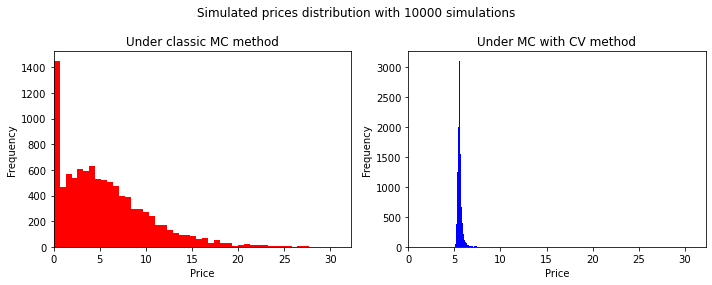

In [120]:
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
ax1.hist(MC[3],bins = 50,color='red')
ax1.set_xlim(0, np.max(MC[3]))
ax1.set_title('Under classic MC method')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

ax2.hist(MC_CV[3],bins = 50,color='blue')
ax2.set_xlim(0, np.max(MC[3]))
ax2.set_title('Under MC with CV method')
ax2.set_xlabel('Price')
ax2.set_ylabel('Frequency')

fig.suptitle(f'Simulated prices distribution with {NPaths} simulations')
fig.tight_layout()
plt.show()

We see that the prices given by the MC with CV methods have lower variance than the prices given by classic MC.

## Example 2

For the second example we set:
\begin{align*}
T &= 1 \\
S &= 400 \\
K &= 500 \\
\sigma &= 0.3 \\
r &= 0.05 \\
\end{align*}

In [121]:
T = 1
S = 400
K = 500
sigma = 0.3
r = 0.05 
NPaths = 10000

In [123]:
MC = AsianMC(T,S,K,sigma,r,NPaths,NSteps)
MC_CV = AsianMCCV(T,S,K,sigma,r,NPaths,NSteps)
print('#### Price w/o CV ####')
print ("lower boundary: ",MC[0])
print ("Higher boundary: ",MC[1])
print("Price:",MC[2])


print('\n #### Price w/ CV ####')
print ("lower boundary: ",MC_CV[0])
print ("Higher boundary: ",MC_CV[1])
print("Price:",MC_CV[2])
print("c*: ",MC_CV[4])

#### Price w/o CV ####
lower boundary:  4.694901285666201
Higher boundary:  5.4894295029872024
Price: 5.092165394326702

 #### Price w/ CV ####
lower boundary:  5.054990323856066
Higher boundary:  5.176873351401479
Price: 5.115931837628772
c*:  -1.1270275943571109


We used 10 000 simulations in this example and, without surprise, the 2 results are very close. The confidence interval of the Monte Carlo with CV is still smaller (by a lot). 